<center>
  <h1><b>Corrosion detection in steel pipes </b></h1>
  <br>
  23 / 02 / 2024
  <br>
  <br>
  <b>Student Name:</b> Abdelaziz Aissa & Tocquec Louis
  <br>
  <br>
  </center>

* **The objective**:
The objective of this challenge is to train a model that have the highest possible score for the segmentation of groove defects using the provided data

# Install Packages

In [ ]:
#install packages
!pip install imutils
!pip install torchsummary

In [95]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import imutils.paths as paths
import glob
import matplotlib.pyplot as plt
import os
from torchvision import transforms
from PIL import Image
from torch.optim import Adam
from torchsummary import summary
from tqdm import tqdm
import random
import shutil
from google.colab import drive
from scipy.ndimage import binary_fill_holes
import pandas as pd
from pathlib import Path

In [ ]:
drive.mount('/content/drive')
drive.mount('/content/drive')
!unzip /content/drive/MyDrive/TP6_Geoscience/data.zip

# Preparing The Dataset

In [220]:
# Define paths
train_images_dir = "/content/Train/images"
train_masks_dir = "/content/Train/labels"
val_images_dir = "/content/Val/images"
val_masks_dir = "/content/Val/labels"

train_data = [(os.path.join(train_images_dir, filename), os.path.join(train_masks_dir, filename)) for filename in os.listdir(train_images_dir)]
val_data = [(os.path.join(val_images_dir, filename), os.path.join(val_masks_dir, filename)) for filename in os.listdir(val_images_dir)]
merged_data = train_data + val_data

# Shuffle the merged data
random.shuffle(merged_data)

# Define split ratio (e.g., 80% train, 20% validation)
split_ratio = 0.90
train_size = int(len(merged_data) * split_ratio)
train_images, train_masks = zip(*merged_data[:train_size])
val_images, val_masks = zip(*merged_data[train_size:])

# Define new directories
new_train_images_dir = "/content/NewTrain2/images"
new_train_masks_dir = "/content/NewTrain2/masks"
new_val_images_dir = "/content/NewVal2/images"
new_val_masks_dir = "/content/NewVal2/masks"

# Create new directories
os.makedirs(new_train_images_dir, exist_ok=True)
os.makedirs(new_train_masks_dir, exist_ok=True)
os.makedirs(new_val_images_dir, exist_ok=True)
os.makedirs(new_val_masks_dir, exist_ok=True)

for src, dest in zip(train_images, [os.path.join(new_train_images_dir, os.path.basename(img)) for img in train_images]):
    shutil.copy(src, dest)

for src, dest in zip(train_masks, [os.path.join(new_train_masks_dir, os.path.basename(mask)) for mask in train_masks]):
    shutil.copy(src, dest)

for src, dest in zip(val_images, [os.path.join(new_val_images_dir, os.path.basename(img)) for img in val_images]):
    shutil.copy(src, dest)

for src, dest in zip(val_masks, [os.path.join(new_val_masks_dir, os.path.basename(mask)) for mask in val_masks]):
    shutil.copy(src, dest)

print("Data merging and splitting complete.")


Data merging and splitting complete.


# Visualize some Images and the Masks from the Data

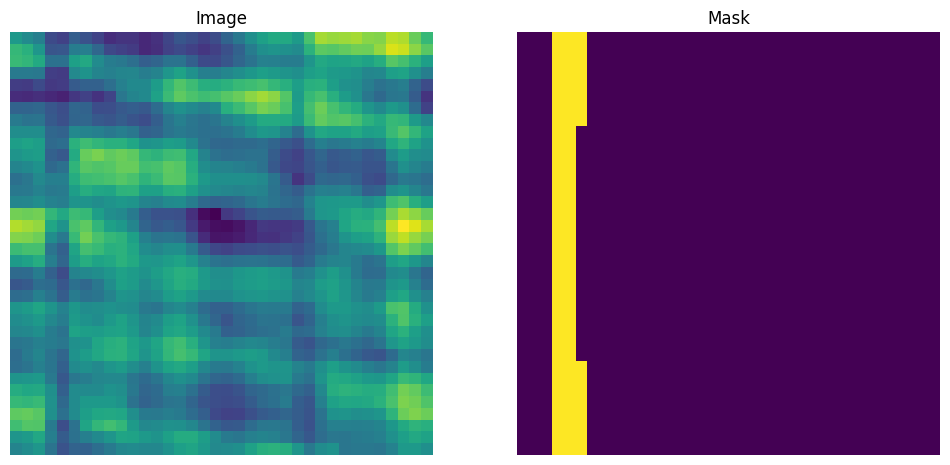

In [221]:
#Path
image_path = "/content/NewTrain/images/well_5_patch_50.npy"
mask_path = "/content/NewTrain/masks/well_5_patch_50.npy"
# Load
image = np.load(image_path)
mask = np.load(mask_path)
mask = binary_fill_holes(mask)
# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(image)
axes[0].set_title('Image')
axes[0].axis('off')
axes[1].imshow(mask)
axes[1].set_title('Mask')
axes[1].axis('off')
plt.show()

In [97]:
#Print the size of the mask and the image
print(image.shape)
print(mask.shape)

(36, 36)
(36, 36)


# Label Refinement

# binary fill holes

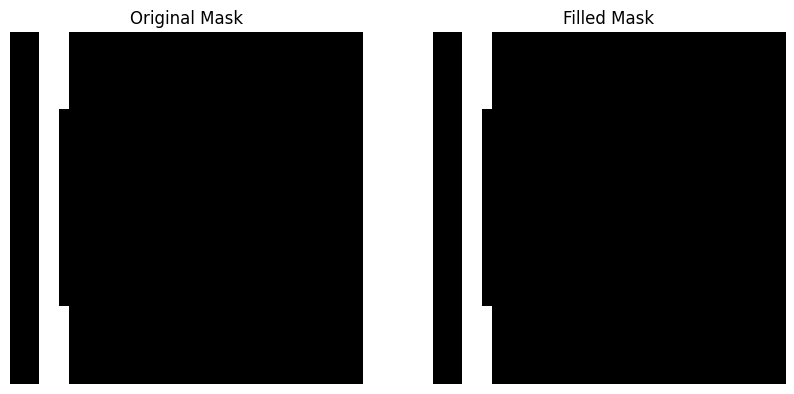

In [98]:
filled = binary_fill_holes(mask)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(mask, cmap='gray')
axes[0].set_title('Original Mask')
axes[0].axis('off')

# Plot filled mask
axes[1].imshow(filled, cmap='gray')
axes[1].set_title('Filled Mask')
axes[1].axis('off')

plt.show()

# Structuring Element & Morphological Operations

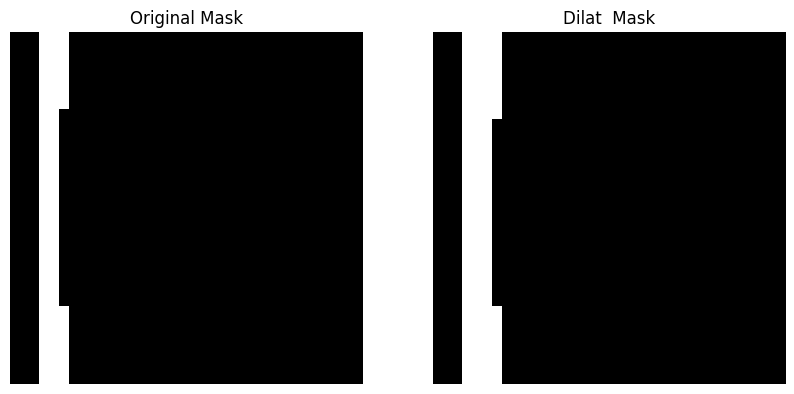

In [99]:
kernel_size = (2, 2)
kernel_shape = cv2.MORPH_RECT
# Create the adaptive structuring element
adaptive_kernel = cv2.getStructuringElement(kernel_shape, kernel_size)
# Apply morphological operations : dilation
result = cv2.dilate(mask, adaptive_kernel)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(mask, cmap='gray')
axes[0].set_title('Original Mask')
axes[0].axis('off')
# Plot filled mask
axes[1].imshow(result, cmap='gray')
axes[1].set_title('Dilat  Mask')
axes[1].axis('off')
plt.show()

# Image Enhancement

CLAHE and bilateral filter

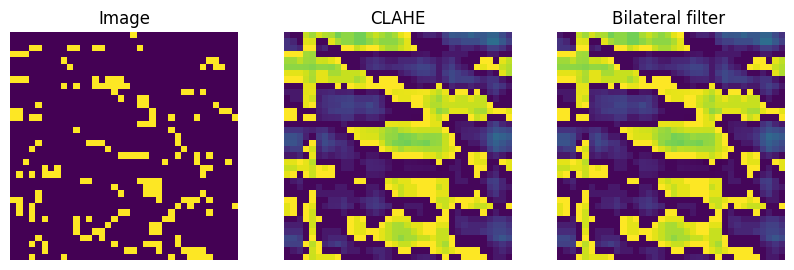

In [100]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
image = np.uint8(image * 255)

# Apply CLAHE to the grayscale image
clahe_img = clahe.apply(image)
#Apply bilateral filter
bilateral_img = cv2.bilateralFilter(clahe_img, d=2, sigmaColor=4, sigmaSpace=4)
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
# Plot Image
image = np.uint8(image /255)

axes[0].imshow(image)
axes[0].set_title('Image')
axes[0].axis('off')

#  Plot CLAHE result
axes[1].imshow(clahe_img)
axes[1].set_title('CLAHE')
axes[1].axis('off')

# Plot Bilateral filter
axes[2].imshow(clahe_img/255)
axes[2].set_title('Bilateral filter ')
axes[2].axis('off')
plt.show()

# Dataset Class

In [210]:
from scipy.ndimage import rotate

class SegmentationDataset(Dataset):
    def __init__(self, imagePaths, maskPaths, filelist, transform=True):
        self.imagePaths = [os.path.join(imagePaths, file) for file in filelist]
        self.maskPaths = [os.path.join(maskPaths, file) for file in filelist]
        self.transform = transform
        self.valid_indices = self._get_valid_indices()

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        idx = self.valid_indices[idx]  # Get the valid index
        imagePath = self.imagePaths[idx]
        maskPath = self.maskPaths[idx]

        # Read image from file
        image = np.load(imagePath)
        if image is None or np.isnan(image).any():
            # Skip images with NaN values
            return self.__getitem__((idx + 1) % len(self.valid_indices))

        # Read mask from file
        mask = np.load(maskPath)
        if mask is None:
            raise FileNotFoundError(f"Mask file not found: {maskPath}")

        if self.transform:
            image, mask = self.apply_numpy_transform(image, mask)

        """kernel_size = (2, 2)
        kernel_shape = cv2.MORPH_RECT
        adaptive_kernel = cv2.getStructuringElement(kernel_shape, kernel_size)
        mask = cv2.dilate(mask, adaptive_kernel)"""
        mask = binary_fill_holes(mask)

        # Convert to PyTorch tensors
        image = torch.from_numpy(np.array(image)).float()
        mask = torch.from_numpy(np.array(mask)).long()

        return image, mask, imagePath, maskPath

    def _get_valid_indices(self):
        valid_indices = []
        for idx, imagePath in enumerate(self.imagePaths):
            image = np.load(imagePath)
            if image is not None and not np.isnan(image).any():
                valid_indices.append(idx)
        return valid_indices


    def apply_numpy_transform(self, image, mask):
        # Apply horizontal and vertical flips with 50% probability
        if np.random.random() > 0.5:
            image = np.fliplr(image)  # Horizontal flip
            mask = np.fliplr(mask)
        if np.random.random() > 0.5:
            image = np.flipud(image)  # Vertical flip
            mask = np.flipud(mask)
        """# Apply 90 and 135-degree rotations with 50% probability
        if np.random.random() > 0.5:
            rotation_angle = np.random.choice([0, 45, 90, 180,135])
            if rotation_angle != 0:
                image = rotate(image, angle=rotation_angle, reshape=False)
                mask = rotate(mask, angle=rotation_angle, reshape=False)"""

        return image, mask


# Models for Segmentation

# UNET Model

We have chosen a compact architecture for the UNET model 🏗️ consisting of:

- 3 down-sampling blocks: (36 x 36), (18 x 18), and (9 x 9).
- 3 up-sampling blocks: (9 x 9), (18 x 18), and (36 x 36).

Here's an illustration of the UNET model:

<img src="https://miro.medium.com/v2/resize:fit:1100/format:webp/1*VUS2cCaPB45wcHHFp_fQZQ.png" alt="UNET Model" width="500" height="250">



In [212]:
class UNet(nn.Module):
    def __init__(self, dropout_prob=0.5):
        super(UNet, self).__init__()

        # Encoder
        self.enc_conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.enc_conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.enc_conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.enc_conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.maxpool = nn.MaxPool2d(2, 2)

        # Additional layers in encoder
        self.enc_conv1_additional = nn.Conv2d(32, 32, 3, padding=1)
        self.enc_conv2_additional = nn.Conv2d(64, 64, 3, padding=1)

        # Dropout layers
        self.dropout = nn.Dropout2d(p=dropout_prob)

        # Decoder
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec_conv1 = nn.Conv2d(128, 64, 3, padding=1)
        self.upconv2 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec_conv2 = nn.Conv2d(64, 32, 3, padding=1)
        self.final_conv = nn.Conv2d(32, 1, 1)

    def forward(self, x):
        # Encoder
        x1 = torch.relu(self.enc_conv1(x))
        x1 = torch.relu(self.enc_conv1_additional(x1))
        x2 = self.maxpool(x1)
        x2 = torch.relu(self.enc_conv2(x2))
        x2 = torch.relu(self.enc_conv2_additional(x2))
        #x2 = self.dropout(x2)
        x3 = self.maxpool(x2)
        x3 = torch.relu(self.enc_conv3(x3))
        x3 = torch.relu(self.enc_conv4(x3))
        #x3 = self.dropout(x3)

        # Decoder
        x = torch.relu(self.upconv1(x3))
        x = torch.cat([x2, x], dim=1)
        x = torch.relu(self.dec_conv1(x))
        x = torch.relu(self.upconv2(x))
        x = torch.cat([x1, x], dim=1)
        x = torch.relu(self.dec_conv2(x))
        x = torch.sigmoid(self.final_conv(x))
        #(x.shape)
        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#Initialize the model
model = UNet()
model.to(device)
summary(model, input_size=(1, 36, 36))

In [ ]:
tensor = torch.rand(1,1, 36, 36).to(device)
model(tensor)

# Attention U-Net

We have chosen to incorporate attention mechanisms into the U-Net to enhance focus on the critical regions of the input image.

Here's an illustration of the Attention U-Net architecture:

<img src="https://idiotdeveloper.com/wp-content/uploads/2021/06/attention_unet-compressed-2.jpg" alt="Attention U-Net architecture" width="500" height="250">



In [213]:
class AttentionBlock(nn.Module):
    """Attention block with learnable parameters"""

    def __init__(self, F_g, F_l, n_coefficients):
        """
        :param F_g: number of feature maps (channels) in previous layer
        :param F_l: number of feature maps in corresponding encoder layer, transferred via skip connection
        :param n_coefficients: number of learnable multi-dimensional attention coefficients
        """
        super(AttentionBlock, self).__init__()

        self.W_gate = nn.Sequential(
            nn.Conv2d(F_g, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(n_coefficients)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(n_coefficients)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(n_coefficients, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, gate, skip_connection):
        """
        :param gate: gating signal from previous layer
        :param skip_connection: activation from corresponding encoder layer
        :return: output activations
        """
        g1 = self.W_gate(gate)
        x1 = self.W_x(skip_connection)
        result = torch.add(g1, x1)
        psi = self.relu(result)
        #print(g1.shape)
        #print(x1.shape)
        psi = self.psi(psi)
        out = skip_connection * psi
        return out

In [248]:
import torch
import torch.nn as nn

class AttUNet(nn.Module):
    def __init__(self, dropout_prob=0.3):
        super(AttUNet, self).__init__()

        # Encoder
        self.enc_conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.enc_conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.enc_conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.enc_conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.maxpool = nn.MaxPool2d(2, 2)



        # Dropout layers
        self.dropout = nn.Dropout2d(p=dropout_prob)

        # Decoder
        self.upconv1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.Att1 = AttentionBlock(F_g=32, F_l=32, n_coefficients=32)
        self.dec_conv1 = nn.Conv2d(64, 32, 3, padding=1)
        self.upconv2 = nn.ConvTranspose2d(32, 16, 2, stride=2)
        self.Att2 = AttentionBlock(F_g=16, F_l=16, n_coefficients=16)
        self.dec_conv2 = nn.Conv2d(32, 16, 3, padding=1)
        self.final_conv = nn.Conv2d(16, 1, 1)

    def forward(self, x):
        # Encoder
        e1 = torch.relu(self.enc_conv1(x)) #32x36x36
        e2 = self.maxpool(e1) #32x18x18
        e2 = torch.relu(self.enc_conv2(e2)) #64x18x18
        e2 = self.dropout(e2) #64x18x18
        e3 = self.maxpool(e2) #64x9x9
        e3 = torch.relu(self.enc_conv3(e3)) #128x9x9
        elif3 = torch.relu(self.enc_conv4(e3)) #128x9x9
        e3 = self.dropout(e3)

        # Decoder
        d2 = torch.relu(self.upconv1(e3)) #[2, 64, 18, 18]
        s2 = self.Att1(gate=d2, skip_connection=e2)
        d2 = torch.cat([s2, d2], dim=1)
        d2 = torch.relu(self.dec_conv1(d2))
        #print(d2.shape)
        d1 = torch.relu(self.upconv2(d2))
        #print(e1.shape)
        #print(d1.shape)
        s1 = self.Att2(gate=d1, skip_connection=e1)
        d1 = torch.cat([s1, d1], dim=1)
        #print(d1.shape)
        d1 = torch.relu(self.dec_conv2(d1))
        out = torch.sigmoid(self.final_conv(d1))
        #(x.shape)

        return out


# ResUNet


We have chosen to incorporate  residual connections within the architecture. These residual connections can help to alleviate the vanishing gradient problem and improve the overall performance of the network

Here's an illustration of the ResUNet architecture:

<img src="https://idiotdeveloper.com/wp-content/uploads/2022/01/MultiResUNET.png" alt="ResUNet architecture" width="500" height="250">


In [274]:

class batchnorm_relu(nn.Module):
    def __init__(self, in_c):
        super().__init__()

        self.bn = nn.BatchNorm2d(in_c)
        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.bn(inputs)
        x = self.relu(x)
        return x

class residual_block(nn.Module):
    def __init__(self, in_c, out_c, stride=1):
        super().__init__()

        """ Convolutional layer """
        self.b1 = batchnorm_relu(in_c)
        self.c1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1, stride=stride)
        self.b2 = batchnorm_relu(out_c)
        self.c2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1, stride=1)

        """ Shortcut Connection (Identity Mapping) """
        self.s = nn.Conv2d(in_c, out_c, kernel_size=1, padding=0, stride=stride)

    def forward(self, inputs):
        x = self.b1(inputs)
        x = self.c1(x)
        x = self.b2(x)
        x = self.c2(x)
        s = self.s(inputs)

        skip = x + s
        return skip

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)
        self.r = residual_block(in_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.upsample(inputs)
        #print(x.shape)
        x = torch.cat([x, skip], axis=1)
        x = self.r(x)
        return x

class build_resunet(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder 1 """
        self.c11 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.br1 = batchnorm_relu(64)
        self.c12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.c13 = nn.Conv2d(1, 64, kernel_size=1, padding=0)

        """ Encoder 2 and 3 """
        self.r2 = residual_block(64, 128, stride=2)
        #self.r3 = residual_block(128, 256, stride=2)

        """ Bridge """
        self.r4 = residual_block(128, 256, stride=2)

        """ Decoder """
        #self.d1 = decoder_block(512, 256)
        self.d2 = decoder_block(256, 128)
        self.d3 = decoder_block(128, 64)

        """ Output """
        self.output = nn.Conv2d(64, 1, kernel_size=1, padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, inputs):
        """ Encoder 1 """
        x = self.c11(inputs)
        x = self.br1(x)
        x = self.c12(x)
        s = self.c13(inputs)
        skip1 = x + s

        """ Encoder 2 and 3 """
        skip2 = self.r2(skip1)
        #skip3 = self.r3(skip2)

        """ Bridge """
        b = self.r4(skip2)

        """ Decoder """
        #d1 = self.d1(b, skip3)
        d2 = self.d2(b, skip2)
        d3 = self.d3(d2, skip1)

        """ output """
        output = self.output(d3)
        output = self.sigmoid(output)

        return output




# Various Losses for Training

Dice Loss + BCE  

In [275]:
class BinaryDiceLoss(nn.Module):
    """Dice loss of binary class
    Args:
        smooth: A float number to smooth loss, and avoid NaN error, default: 1
        p: Denominator value: \sum{x^p} + \sum{y^p}, default: 2
        predict: A tensor of shape [N, *]
        target: A tensor of shape same with predict
        reduction: Reduction method to apply, return mean over batch if 'mean',
            return sum if 'sum', return a tensor of shape [N,] if 'none'
    Returns:
        Loss tensor according to arg reduction
    Raise:
        Exception if unexpected reduction
    """
    def __init__(self, smooth=1, p=2, reduction='mean'):
        super(BinaryDiceLoss, self).__init__()
        self.smooth = smooth
        self.p = p
        self.reduction = reduction
        self.bce=nn.BCELoss()

    def forward(self, predict, target):
        assert predict.shape[0] == target.shape[0], "predict & target batch size don't match"
        predict = predict.contiguous().view(predict.shape[0], -1)
        target = target.contiguous().view(target.shape[0], -1)

        num = torch.sum(torch.mul(predict, target), dim=1) + self.smooth
        den = torch.sum(predict.pow(self.p) + target.pow(self.p), dim=1) + self.smooth
        bce_loss = self.bce(predict, target)
        loss = (1 - num / den)+bce_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        elif self.reduction == 'none':
            return loss
        else:
            raise Exception('Unexpected reduction {}'.format(self.reduction))

Focal Loss

In [276]:
class FocalLoss(nn.modules.loss._WeightedLoss):

    def __init__(self, gamma=0, size_average=None, ignore_index=-100,
                 reduce=None, balance_param=1.0):
        super(FocalLoss, self).__init__(size_average)
        self.gamma = gamma
        self.size_average = size_average
        self.ignore_index = ignore_index
        self.balance_param = balance_param
        self.bce=nn.BCELoss()

    def forward(self, input, target):
        # inputs and targets are assumed to be BatchxClasses
        assert len(input.shape) == len(target.shape)
        assert input.size(0) == target.size(0)
        assert input.size(1) == target.size(1)
        # compute the negative likelyhood
        bce_loss = self.bce(input.view(-1), target.float().view(-1))
        logpt = - bce_loss
        pt = torch.exp(logpt)
        # compute the loss
        focal_loss = -( (1-pt)**self.gamma ) * logpt
        balanced_focal_loss = self.balance_param * focal_loss
        loss=balanced_focal_loss+bce_loss
        return loss

## Start Training

In [277]:
#batch size for data loaders
batch_size = 16
# Train Set
IMAGE_DATASET_PATH = "/content/NewTrain2/images/"
IMAGE_Label_PATH = "/content/NewTrain2/masks"
imagePaths_full = sorted(glob.glob(IMAGE_DATASET_PATH + "*.npy"))
imagePaths = [os.path.basename(path) for path in imagePaths_full]
train_dataset = SegmentationDataset(IMAGE_DATASET_PATH, IMAGE_Label_PATH, imagePaths)
# Validation Set
IMAGE_DATASET_PATH_VAL = "/content/NewVal2/images/"
IMAGE_Label_PATH_VAL = "/content/NewVal2/masks/"
val_imagePaths_full = sorted(glob.glob(IMAGE_DATASET_PATH_VAL + "*.npy"))
val_imagePaths = [os.path.basename(path) for path in val_imagePaths_full]
val_dataset = SegmentationDataset(IMAGE_DATASET_PATH_VAL, IMAGE_Label_PATH_VAL, val_imagePaths)

#Define data loaders
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


Displaying Images and Mask from train set :

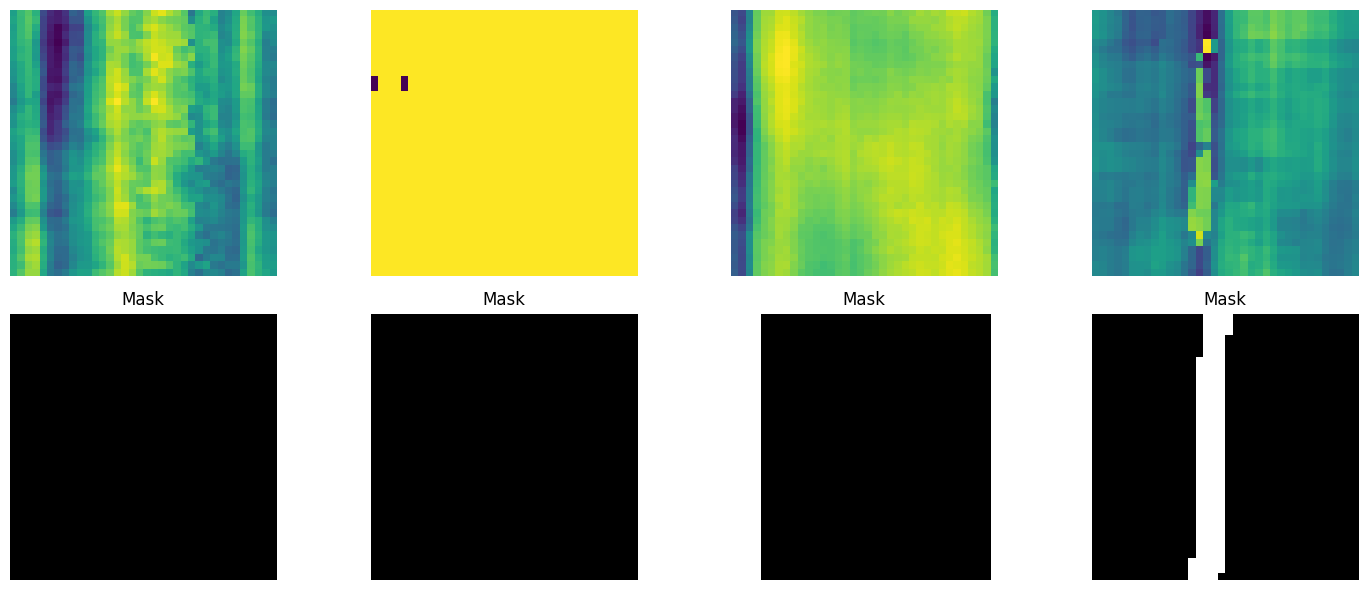

In [278]:
for images, masks,image_path,mask_path in train_loader:
    num_images_to_plot = min(4, len(images))

    fig, axes = plt.subplots(2, num_images_to_plot, figsize=(15, 6))

    for i in range(num_images_to_plot):
        axes[0, i].imshow(images[i])
        #axes[0, i].set_title(image_path[i])
        #print(image_path[i])
        #print(mask_path[i])
        axes[0, i].axis('off')

        axes[1, i].imshow(masks[i], cmap='gray')
        axes[1, i].set_title('Mask')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()
    break

# Evalution Score

Dice Score

In [280]:
def dice_coeff(prediction, target):

    mask = np.zeros_like(prediction)
    mask[prediction >= 0.5] = 1

    inter = np.sum(mask * target)
    union = np.sum(mask) + np.sum(target)
    epsilon=1e-6
    result = np.mean(2 * inter / (union + epsilon))
    return result

Validation function

In [281]:
#Validation function
def validation(model, val_loader, criterion, device):
    model.eval()
    total_val_loss = 0
    total_val_dice_coef = 0
    sample = 0
    nb_batch = 0
    with torch.no_grad():
        with tqdm(val_loader, desc='Validation', unit='batch') as tqdm_loader:
            for images, masks,_ ,_ in tqdm_loader:
                images = images.to(device)
                masks = masks.to(device)
                masks = masks.float()
                images = images.unsqueeze(1)
                masks = masks.unsqueeze(1)
                pred = model(images)
                val_loss = criterion(pred, masks)
                y_pred = pred.data.cpu().numpy().ravel()
                y_true = masks.data.cpu().numpy().ravel()
                val_dice_coef = dice_coeff(y_pred, y_true)
                total_val_loss += val_loss.item()
                total_val_dice_coef += val_dice_coef.item()
                sample += len(images)
                nb_batch += 1
                tqdm_loader.set_postfix(loss=val_loss.item(), DiceCoef=val_dice_coef.item())
    overall_val_loss = total_val_loss / nb_batch
    overall_val_dice_coef = total_val_dice_coef / nb_batch
    print(f"Validation Loss: {overall_val_loss}")
    print(f"Validation Dice Score Coef: {overall_val_dice_coef}")
    return overall_val_loss,overall_val_dice_coef

# Training

In [286]:
#Model
model = UNet()
model.to(device)
#Hyper Parameters
lr = 0.001
weight_decay = 1e-5
betas = (0.9, 0.999)
optimizer = Adam(model.parameters(), lr=lr)
#criterion = FocalLoss() #FocalLoss + BCE
#criterion =BinaryDiceLoss() #DiceLoss + BCE
criterion = nn.BCELoss() #Binary Score Entropy
num_epochs = 25
train_loss=[]
train_dice_score=[]
validation_loss=[]
validation_dice_score=[]
for e in range(num_epochs):
    model.train()
    total_train_loss = 0
    total_dice_coef = 0
    sample = 0
    nb_batch = 0
    with tqdm(train_loader, desc=f'Epoch {e+1}/{num_epochs}', unit='batch') as tqdm_loader:
        for images, masks,_,_ in tqdm_loader:
            optimizer.zero_grad()
            images = images.to(device)
            masks = masks.to(device)
            masks = masks.float()
            images = images.unsqueeze(1)
            masks = masks.unsqueeze(1)
            pred = model(images)
            loss = criterion(pred, masks).mean().float()
            y_pred = pred.data.cpu().numpy().ravel()
            y_true = masks.data.cpu().numpy().ravel()
            dice_coef = dice_coeff(y_pred, y_true)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            total_dice_coef += dice_coef.item()
            sample += len(images)
            nb_batch += 1
            tqdm_loader.set_postfix(loss=loss.item(), DiceCoef=dice_coef.item())

        overall_loss=total_train_loss/nb_batch
        overall_score = total_dice_coef / nb_batch
        train_loss.append(overall_loss)
        train_dice_score.append(overall_score)
    print(f"Epoch [{e+1}/{num_epochs}], Total Train Loss: {total_train_loss}")
    print(f"Epoch [{e+1}/{num_epochs}], Dice Score for Training : {overall_score}")
    # Validation
    val_loss,val_dice_coef=validation(model, val_loader, criterion, device)
    validation_loss.append(val_loss)
    validation_dice_score.append(val_dice_coef)
    # Save the model
    save_dir = "/content"
    model_path = os.path.join(save_dir, f"model_epoch_{e+1}.pt")
    torch.save(model.state_dict(), model_path)

Epoch 1/25: 100%|██████████| 544/544 [00:10<00:00, 52.01batch/s, DiceCoef=0.727, loss=0.129]


Epoch [1/25], Total Train Loss: 113.59307684749365
Epoch [1/25], Dice Score for Training : 0.16205019994640574


Validation: 100%|██████████| 61/61 [00:00<00:00, 73.45batch/s, DiceCoef=0, loss=0.0395]


Validation Loss: 0.1385884556125422
Validation Dice Score Coef: 0.4764264477515143


Epoch 2/25: 100%|██████████| 544/544 [00:11<00:00, 49.13batch/s, DiceCoef=0.702, loss=0.136]


Epoch [2/25], Total Train Loss: 73.46460085362196
Epoch [2/25], Dice Score for Training : 0.599946195995753


Validation: 100%|██████████| 61/61 [00:01<00:00, 53.64batch/s, DiceCoef=0, loss=0.0384]


Validation Loss: 0.12549071508597154
Validation Dice Score Coef: 0.5608605603526416


Epoch 3/25: 100%|██████████| 544/544 [00:10<00:00, 51.05batch/s, DiceCoef=0.683, loss=0.0986]


Epoch [3/25], Total Train Loss: 67.73399613052607
Epoch [3/25], Dice Score for Training : 0.6553588585847459


Validation: 100%|██████████| 61/61 [00:00<00:00, 73.73batch/s, DiceCoef=0, loss=0.0424]


Validation Loss: 0.11784038863709716
Validation Dice Score Coef: 0.6365327041072537


Epoch 4/25: 100%|██████████| 544/544 [00:10<00:00, 53.38batch/s, DiceCoef=0.798, loss=0.063]


Epoch [4/25], Total Train Loss: 62.97927204892039
Epoch [4/25], Dice Score for Training : 0.6836593031675653


Validation: 100%|██████████| 61/61 [00:01<00:00, 53.15batch/s, DiceCoef=0, loss=0.0162]


Validation Loss: 0.1134059234965043
Validation Dice Score Coef: 0.5860071534192287


Epoch 5/25: 100%|██████████| 544/544 [00:10<00:00, 53.60batch/s, DiceCoef=0.759, loss=0.073]


Epoch [5/25], Total Train Loss: 56.34893110021949
Epoch [5/25], Dice Score for Training : 0.6982462388090899


Validation: 100%|██████████| 61/61 [00:01<00:00, 59.72batch/s, DiceCoef=0, loss=0.0309]


Validation Loss: 0.10148635066923548
Validation Dice Score Coef: 0.6355680318548921


Epoch 6/25: 100%|██████████| 544/544 [00:10<00:00, 52.08batch/s, DiceCoef=0.816, loss=0.0823]


Epoch [6/25], Total Train Loss: 54.32325966283679
Epoch [6/25], Dice Score for Training : 0.709633218659962


Validation: 100%|██████████| 61/61 [00:00<00:00, 73.68batch/s, DiceCoef=0, loss=0.0165]


Validation Loss: 0.09933870047575137
Validation Dice Score Coef: 0.642984989229772


Epoch 7/25: 100%|██████████| 544/544 [00:10<00:00, 51.63batch/s, DiceCoef=0.727, loss=0.0836]


Epoch [7/25], Total Train Loss: 52.2582838088274
Epoch [7/25], Dice Score for Training : 0.7217443882067888


Validation: 100%|██████████| 61/61 [00:00<00:00, 72.94batch/s, DiceCoef=0, loss=0.055]


Validation Loss: 0.09525535060245482
Validation Dice Score Coef: 0.6793363894539728


Epoch 8/25: 100%|██████████| 544/544 [00:10<00:00, 51.65batch/s, DiceCoef=0.74, loss=0.17]


Epoch [8/25], Total Train Loss: 50.079499173909426
Epoch [8/25], Dice Score for Training : 0.7357337522623519


Validation: 100%|██████████| 61/61 [00:00<00:00, 73.35batch/s, DiceCoef=0, loss=0.0376]


Validation Loss: 0.09237725632723237
Validation Dice Score Coef: 0.6774111673523173


Epoch 9/25: 100%|██████████| 544/544 [00:10<00:00, 52.50batch/s, DiceCoef=0.649, loss=0.0946]


Epoch [9/25], Total Train Loss: 49.47834546491504
Epoch [9/25], Dice Score for Training : 0.7375188386783444


Validation: 100%|██████████| 61/61 [00:00<00:00, 76.51batch/s, DiceCoef=0, loss=0.0339]


Validation Loss: 0.09045032888162331
Validation Dice Score Coef: 0.6883271468202911


Epoch 10/25: 100%|██████████| 544/544 [00:10<00:00, 53.65batch/s, DiceCoef=0.789, loss=0.0878]


Epoch [10/25], Total Train Loss: 47.69451656192541
Epoch [10/25], Dice Score for Training : 0.7475176455478589


Validation: 100%|██████████| 61/61 [00:01<00:00, 54.15batch/s, DiceCoef=0, loss=0.0261]


Validation Loss: 0.08654891049153492
Validation Dice Score Coef: 0.6978777495294578


Epoch 11/25: 100%|██████████| 544/544 [00:09<00:00, 55.21batch/s, DiceCoef=0.826, loss=0.0636]


Epoch [11/25], Total Train Loss: 46.53751788660884
Epoch [11/25], Dice Score for Training : 0.7532303100882904


Validation: 100%|██████████| 61/61 [00:00<00:00, 66.06batch/s, DiceCoef=0, loss=0.0287]


Validation Loss: 0.08415602553696906
Validation Dice Score Coef: 0.6994251894306094


Epoch 12/25: 100%|██████████| 544/544 [00:10<00:00, 52.29batch/s, DiceCoef=0.769, loss=0.0763]


Epoch [12/25], Total Train Loss: 45.57713785395026
Epoch [12/25], Dice Score for Training : 0.7584380707644434


Validation: 100%|██████████| 61/61 [00:00<00:00, 74.84batch/s, DiceCoef=0, loss=0.0364]


Validation Loss: 0.084620685912058
Validation Dice Score Coef: 0.710177130534098


Epoch 13/25: 100%|██████████| 544/544 [00:10<00:00, 51.72batch/s, DiceCoef=0.823, loss=0.0751]


Epoch [13/25], Total Train Loss: 45.085740361362696
Epoch [13/25], Dice Score for Training : 0.7625246884107965


Validation: 100%|██████████| 61/61 [00:00<00:00, 75.32batch/s, DiceCoef=0, loss=0.025]


Validation Loss: 0.08337613482211458
Validation Dice Score Coef: 0.7118442027892807


Epoch 14/25: 100%|██████████| 544/544 [00:10<00:00, 50.40batch/s, DiceCoef=0.852, loss=0.0632]


Epoch [14/25], Total Train Loss: 44.13780810683966
Epoch [14/25], Dice Score for Training : 0.7643009428052381


Validation: 100%|██████████| 61/61 [00:00<00:00, 73.72batch/s, DiceCoef=0, loss=0.0544]


Validation Loss: 0.086207492979335
Validation Dice Score Coef: 0.7135913079772526


Epoch 15/25: 100%|██████████| 544/544 [00:10<00:00, 50.37batch/s, DiceCoef=0.845, loss=0.0537]


Epoch [15/25], Total Train Loss: 43.522134594619274
Epoch [15/25], Dice Score for Training : 0.7686589572494684


Validation: 100%|██████████| 61/61 [00:00<00:00, 72.12batch/s, DiceCoef=0, loss=0.0557]


Validation Loss: 0.08553522208430728
Validation Dice Score Coef: 0.7267248746033315


Epoch 16/25: 100%|██████████| 544/544 [00:10<00:00, 53.98batch/s, DiceCoef=0.805, loss=0.0734]


Epoch [16/25], Total Train Loss: 42.984371427446604
Epoch [16/25], Dice Score for Training : 0.7711704069233043


Validation: 100%|██████████| 61/61 [00:01<00:00, 57.50batch/s, DiceCoef=0, loss=0.0201]


Validation Loss: 0.07948184352307046
Validation Dice Score Coef: 0.7141161938101774


Epoch 17/25: 100%|██████████| 544/544 [00:09<00:00, 55.53batch/s, DiceCoef=0.878, loss=0.0503]


Epoch [17/25], Total Train Loss: 42.227714985609055
Epoch [17/25], Dice Score for Training : 0.7742457855431194


Validation: 100%|██████████| 61/61 [00:00<00:00, 68.15batch/s, DiceCoef=0, loss=0.0228]


Validation Loss: 0.07938429594162058
Validation Dice Score Coef: 0.7215743006876935


Epoch 18/25: 100%|██████████| 544/544 [00:10<00:00, 51.95batch/s, DiceCoef=0.758, loss=0.0989]


Epoch [18/25], Total Train Loss: 41.65380726382136
Epoch [18/25], Dice Score for Training : 0.7764748475682114


Validation: 100%|██████████| 61/61 [00:00<00:00, 73.25batch/s, DiceCoef=0, loss=0.0243]


Validation Loss: 0.07793359256914405
Validation Dice Score Coef: 0.7216429524549447


Epoch 19/25: 100%|██████████| 544/544 [00:10<00:00, 51.68batch/s, DiceCoef=0.788, loss=0.0599]


Epoch [19/25], Total Train Loss: 41.91648418083787
Epoch [19/25], Dice Score for Training : 0.7782068559266904


Validation: 100%|██████████| 61/61 [00:00<00:00, 72.02batch/s, DiceCoef=0, loss=0.0229]


Validation Loss: 0.07701856670443152
Validation Dice Score Coef: 0.7239282373558237


Epoch 20/25: 100%|██████████| 544/544 [00:10<00:00, 50.55batch/s, DiceCoef=0.767, loss=0.106]


Epoch [20/25], Total Train Loss: 41.11279437318444
Epoch [20/25], Dice Score for Training : 0.7808019286760262


Validation: 100%|██████████| 61/61 [00:00<00:00, 75.48batch/s, DiceCoef=0, loss=0.0158]


Validation Loss: 0.08089220380318947
Validation Dice Score Coef: 0.7111346990227859


Epoch 21/25: 100%|██████████| 544/544 [00:11<00:00, 48.27batch/s, DiceCoef=0.734, loss=0.11]


Epoch [21/25], Total Train Loss: 40.62974090874195
Epoch [21/25], Dice Score for Training : 0.7836723060476483


Validation: 100%|██████████| 61/61 [00:00<00:00, 74.73batch/s, DiceCoef=0, loss=0.0177]


Validation Loss: 0.07718089778648048
Validation Dice Score Coef: 0.7224029109363278


Epoch 22/25: 100%|██████████| 544/544 [00:10<00:00, 53.31batch/s, DiceCoef=0.823, loss=0.0714]


Epoch [22/25], Total Train Loss: 40.03627011924982
Epoch [22/25], Dice Score for Training : 0.7851394301187511


Validation: 100%|██████████| 61/61 [00:01<00:00, 55.07batch/s, DiceCoef=0, loss=0.0255]


Validation Loss: 0.07577304688633466
Validation Dice Score Coef: 0.7345487449095289


Epoch 23/25: 100%|██████████| 544/544 [00:09<00:00, 55.58batch/s, DiceCoef=0.767, loss=0.08]


Epoch [23/25], Total Train Loss: 39.865074219182134
Epoch [23/25], Dice Score for Training : 0.7867435839159023


Validation: 100%|██████████| 61/61 [00:01<00:00, 60.44batch/s, DiceCoef=0, loss=0.0466]


Validation Loss: 0.08013811112060899
Validation Dice Score Coef: 0.7102465027577701


Epoch 24/25: 100%|██████████| 544/544 [00:10<00:00, 52.85batch/s, DiceCoef=0.816, loss=0.0729]


Epoch [24/25], Total Train Loss: 40.32127543911338
Epoch [24/25], Dice Score for Training : 0.7909084328831009


Validation: 100%|██████████| 61/61 [00:00<00:00, 74.01batch/s, DiceCoef=0, loss=0.0513]


Validation Loss: 0.07979067698976056
Validation Dice Score Coef: 0.7298543342048023


Epoch 25/25: 100%|██████████| 544/544 [00:10<00:00, 51.74batch/s, DiceCoef=0.88, loss=0.0541]


Epoch [25/25], Total Train Loss: 39.57417961023748
Epoch [25/25], Dice Score for Training : 0.7915725470382418


Validation: 100%|██████████| 61/61 [00:00<00:00, 75.41batch/s, DiceCoef=0, loss=0.0457]

Validation Loss: 0.07807571184439738
Validation Dice Score Coef: 0.7373277635965565


Visualizing the results:

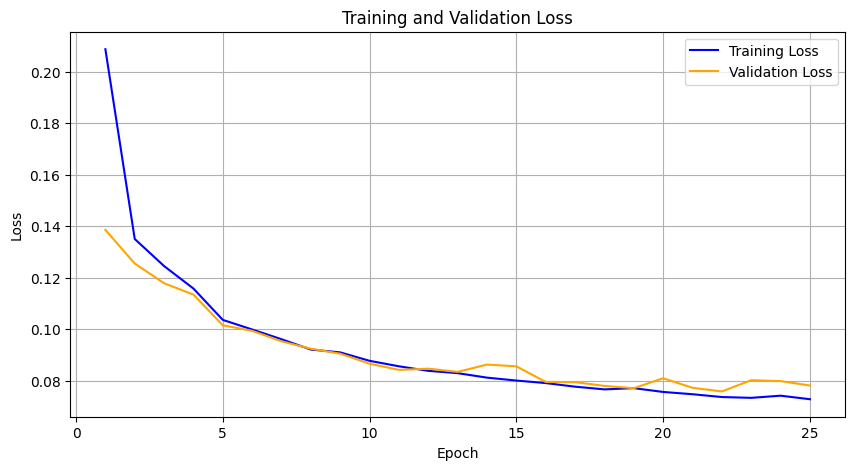

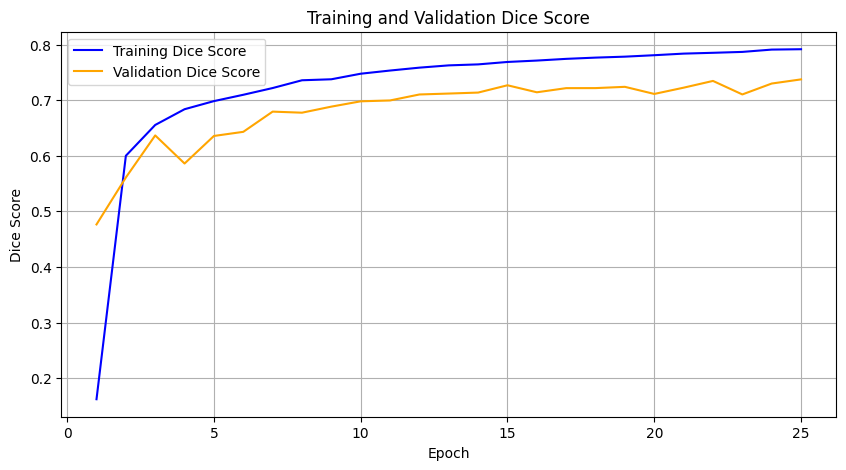

In [287]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss', color='blue')
plt.plot(range(1, len(validation_loss) + 1), validation_loss, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation dice score
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_dice_score) + 1), train_dice_score, label='Training Dice Score', color='blue')
plt.plot(range(1, len(validation_dice_score) + 1), validation_dice_score, label='Validation Dice Score', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.title('Training and Validation Dice Score')
plt.legend()
plt.grid(True)
plt.show()

# Generate the mask of the test images and saving them in .csv file

In [ ]:
pred_csv = 'pred_focal_81.csv'
img_save_dir = Path('/content/Test/images')
threshold = 0.5
results = []
length = np.arange(1, 36*36+1)
results.append([''] + length.tolist())

# Looping over image files
for img_path in tqdm(sorted(img_save_dir.glob('*.npy'))):
    patch_name = img_path.stem
    image = np.load(img_path)
    image = torch.from_numpy(image).float()
    image = image.to(device)
    image = image.unsqueeze(0).unsqueeze(0)
    pred = model(image)
    mask = (pred > threshold).float()
    mask = mask.view(-1)
    results.append([patch_name] + mask.cpu().numpy().tolist())  # Appending patch name and mask values as a list


In [ ]:
# Saving results to CSV
df = pd.DataFrame(results[1:], columns=results[0])
df.to_csv(pred_csv, index=False)